In [21]:
import numpy as np
import scipy.fft as fft
import scipy.optimize
import matplotlib.pyplot as plt

In [23]:
# Setting up the signal
F_s =1e6
T = 1/F_s
f_0 = 1e5
omega_0 = 2*np.pi*f_0
phi = np.pi/8
A = 1

N = 513
n_0 = -256
t = np.arange(n_0, n_0+N)*T

SNR_db = np.arange(-10, 70, 10)
SNR_num = 10**(SNR_db/10)

ks = np.arange(10,22,2)
M = 2**ks

repetition = np.arange(200)
sample = np.arange(N)

#1a)
omega_vars = np.zeros((len(SNR_db), len(M)))
phi_vars = np.zeros((len(SNR_db), len(M)))

# for i, SNR in enumerate(SNR_num):
#     for j, m in enumerate(M):
#         temp_omega = np.zeros(100)
#         temp_phi = np.zeros(100)
#         for k in range(100):
#             noise_real = np.random.normal(0, np.sqrt(A**2/(2*SNR)), N)
#             noise_complex = np.random.normal(0, np.sqrt(A**2/(2*SNR)), N)*1j
#             signal = A*np.exp(1j*(omega_0*t+phi)) + noise_real+ noise_complex
#             F = fft.fft(signal, n=m, norm='ortho')
#             m_star = np.argmax(np.abs(F))
#             omega_hat = 2*np.pi*m_star/(m*T)
#             phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F[m_star])
#             temp_omega[k] = omega_hat- omega_0
#             temp_phi[k] = phi_hat - phi # Fixes wrapping
#         print('SNR: ', SNR_db[i], 'M: ', m, 'omega: ', np.var(temp_omega, ddof=1), 'phi: ', np.var(temp_phi, ddof=1))
#         omega_vars[i,j] = np.var(temp_omega, ddof=1)
#         phi_vars[i,j] = np.var(temp_phi, ddof=1)

t.shape
        

(513,)

In [24]:
k_arr, snr_arr, repetition_arr, t_arr = np.meshgrid(M, SNR_num, repetition, t, indexing='ij')

signal = A*np.exp(1j*(omega_0*t_arr+phi)) + np.random.normal(0, np.sqrt(A**2/(2*snr_arr)), t_arr.shape) + 1j*np.random.normal(0, np.sqrt(A**2/(2*snr_arr)), t_arr.shape)

print(signal.shape)

temp_phi = np.zeros(signal.shape[:-1], dtype=float)
temp_omega = np.zeros(signal.shape[:-1], dtype=float)

for i, signalpack in enumerate(signal):
    F = fft.fft(signalpack, n=M[i], norm='ortho')

    m_star = np.argmax(np.abs(F), axis=-1)
    omega_hat = 2*np.pi*m_star/(M[i]*T) #dim: SNR x repetition
    
    # Get peak value of FFT
    s_idx, r_idx = np.indices(m_star.shape)
    F_peak = F[s_idx, r_idx, m_star]
    phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F_peak)
    temp_omega[i] = omega_hat - omega_0
    temp_phi[i] = phi_hat - phi # Fixes wrapping
    print(f"Done for {M[i]}")


(6, 8, 200, 513)
Done for 1024
Done for 4096
Done for 16384
Done for 65536
Done for 262144
Done for 1048576


In [25]:
var_omega = np.var(temp_omega, axis=-1, ddof=1)
var_phi = np.var(temp_phi, axis=-1, ddof=1)

var_omega

array([[6.05419946e+06, 1.88247765e+05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.12587084e+05, 4.37451385e+05, 3.49417176e+04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.12892386e+05, 5.40938879e+04, 3.13315169e+04, 6.35203179e+03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.46222077e+05, 4.92474151e+04, 5.31899520e+03, 2.14113172e+03,
        6.01392189e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.02940186e+05, 4.33496464e+04, 4.38318831e+03, 5.13732465e+02,
        1.23500182e+02, 7.95476276e+01, 0.00000000e+00, 0.00000000e+00],
       [4.51983669e+05, 4.53577945e+04, 4.50748148e+03, 4.59643398e+02,
        4.37937765e+01, 9.71069977e+00, 5.55361091e+00, 0.00000000e+00]])

513


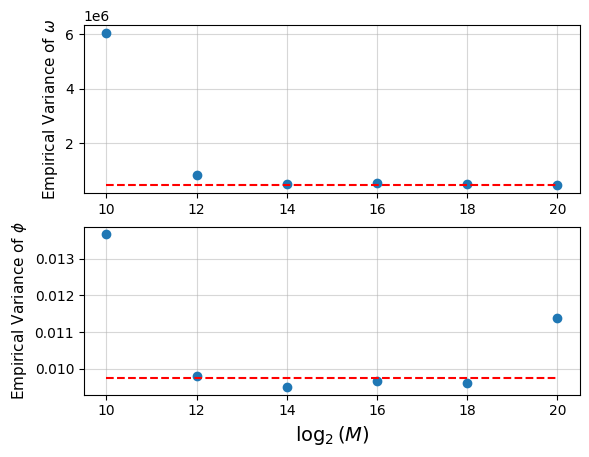

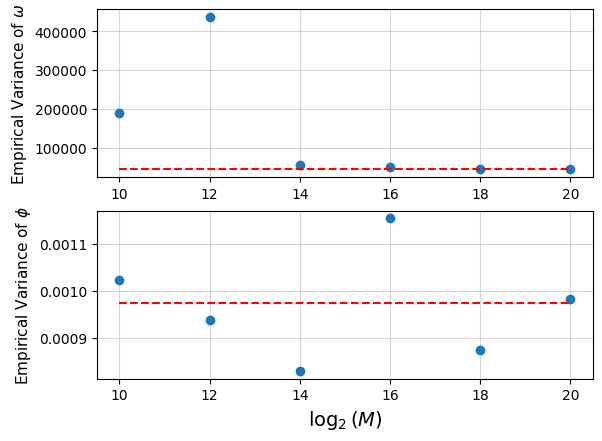

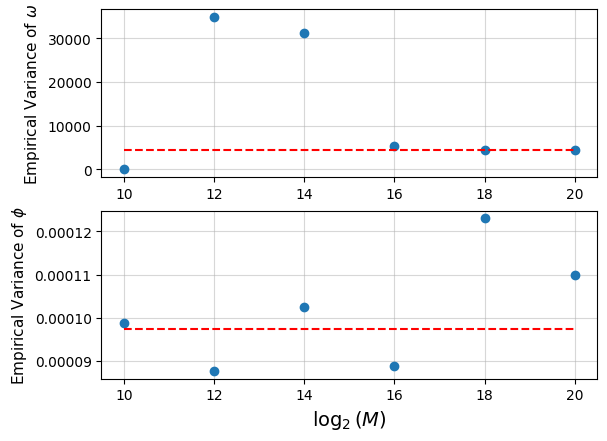

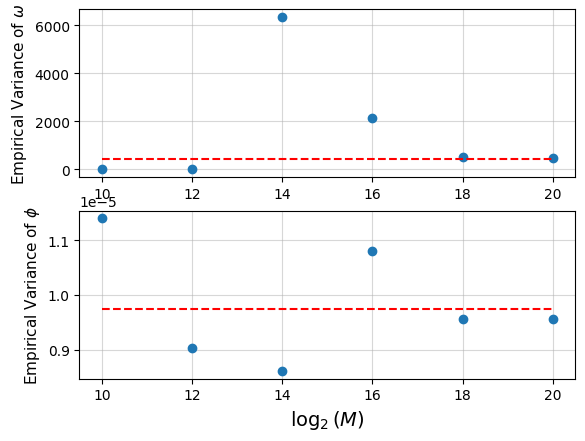

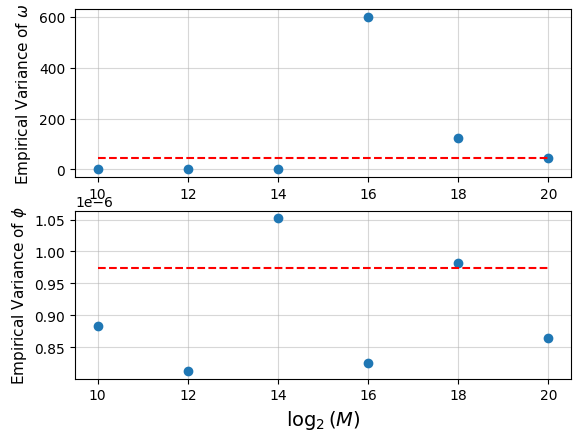

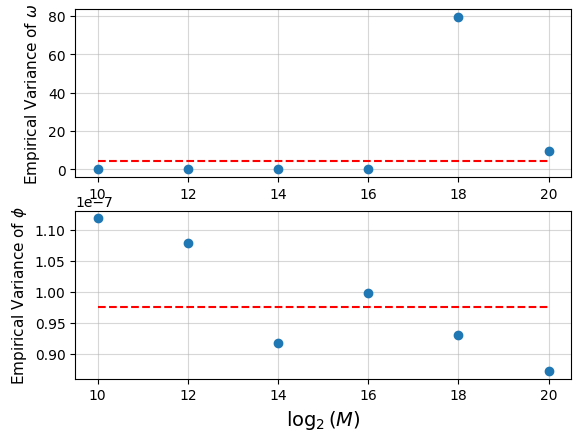

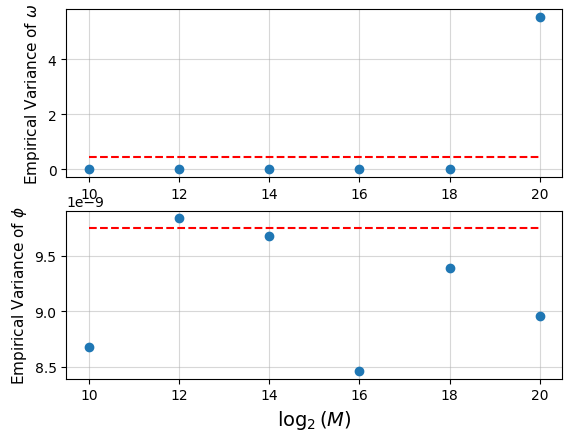

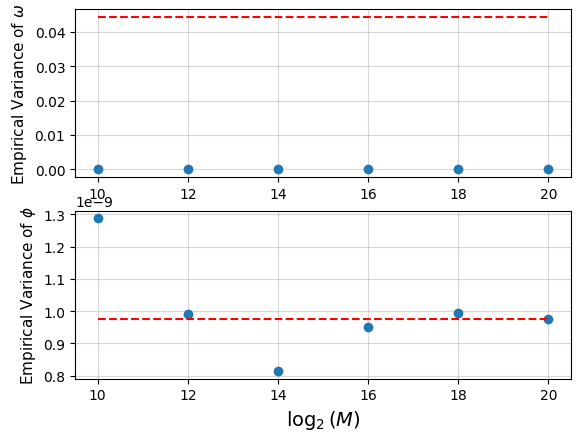

In [40]:
# Plotting
print(N)
crlb_omega = 12*(1/(2*SNR_num))/(T**2*N*(N+1)*(N-1))

P = N*(N-1)/2
Q = N*(N-1)*(2*N-1)/6

crlb_phi = (12*(1/(2*SNR_num))*(n_0**2*N+2*n_0*P+Q))/(N**2*(N-1)*(N+1))
for i, db in enumerate(SNR_db):
    plt.figure()
    plt.subplot(211)
    plt.plot(ks, var_omega[:,i], 'o')
    plt.plot(ks, crlb_omega[i]*np.ones(len(ks)), 'r--')
    plt.ylabel('Empirical Variance of $\omega$', fontsize=11)
    plt.grid(alpha=0.5)
    plt.subplot(212)
    plt.plot(ks, var_phi[:,i], 'o')
    plt.plot(ks, crlb_phi[i]*np.ones(len(ks)), 'r--')
    plt.ylabel('Empirical Variance of $\phi$', fontsize=11)
    plt.xlabel('$\log_2(M)$', fontsize=14)
    plt.grid(alpha=0.5)

In [41]:
# 1b)

m = 2**10

def objective(omega, signal):
    n = np.arange(N)
    return -np.abs((1/N)*np.sum(signal*np.exp(-1j*omega*n*T)))

def F_func(omega, signal):
    n = np.arange(N)
    return (1/N)*np.sum(signal*np.exp(-1j*omega*n*T))

for i, SNR in enumerate(SNR_num):
    temp_omega = np.zeros(1000)
    temp_phi = np.zeros(1000)

    noise_real = np.random.normal(0, A**2/(2*SNR), N)
    noise_complex = np.random.normal(0, A**2/(2*SNR), N)*1j
    signal = A*np.exp(1j*(omega_0*t+phi)) + noise_real+ noise_complex
    F = fft.fft(signal, n=m, norm='ortho')
    m_star = np.argmax(np.abs(F))
    omega_hat = 2*np.pi*m_star/(m*T)
    phi_hat = np.angle(np.exp(-1j*omega_hat*n_0*T)*F[m_star])
    res = scipy.optimize.minimize(objective, omega_hat, args=( signal),method='Nelder-Mead')
    omega_hat_new = res.x[0]
    phi_hat_new = np.angle(np.exp(-1j*omega_hat_new*n_0*T)*F_func(omega_hat_new, signal))

    
    print(omega_hat)
    print(res.x)
    print(omega_0)
    print(f"Estimate: {phi_hat_new}")
    print(f"Real value: {phi}")
        

625864.1614573416
[627632.86383947]
628318.5307179586
Estimate: 0.24082247448418545
Real value: 0.39269908169872414
625864.1614573416
[628371.7024722]
628318.5307179586
Estimate: 0.3833153359511256
Real value: 0.39269908169872414
625864.1614573416
[628308.16332612]
628318.5307179586
Estimate: 0.3934163220092274
Real value: 0.39269908169872414
625864.1614573416
[628316.58351456]
628318.5307179586
Estimate: 0.39297767467022526
Real value: 0.39269908169872414
625864.1614573416
[628318.64662336]
628318.5307179586
Estimate: 0.3926897489310006
Real value: 0.39269908169872414
625864.1614573416
[628318.54578487]
628318.5307179586
Estimate: 0.3926963099152187
Real value: 0.39269908169872414
625864.1614573416
[628318.53167914]
628318.5307179586
Estimate: 0.3926991122336661
Real value: 0.39269908169872414
625864.1614573416
[628318.53080482]
628318.5307179586
Estimate: 0.39269905862125165
Real value: 0.39269908169872414
